- Written on 7 September 2018 by Raunak
- The input trajectories to this file need to have `laneNum` as one of the attributes of the dictionary containing the actual data in the traj_lab_dict data structure

In [39]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
from scipy.stats import entropy

import hgail.misc.utils

import utils
import visualize_utils

from copy import deepcopy

In [2]:
def filename2label(fn):
    s = fn.find('-') + 1
    e = fn.find('.')
    return fn[s:e]

In [3]:
filenames = [i for i in utils.NGSIM_FILENAME_TO_ID.keys() if '101' in i]

model_labels = [
    'rails_smoothed_off_brake_1000_2_fine'
]

n_itrs = dict([(i, 1000) for i in model_labels])
for i in model_labels:
    if 'fine' in i:
        n_itrs[i] = 200

In [4]:
traj_lab_dict = \
visualize_utils.get_trajs_dict(
model_labels, files_to_use = \
[utils.NGSIM_FILENAME_TO_ID[i] - 1 for i in filenames])

valdirs, params_filepaths = \
visualize_utils.get_val_dirs_and_params_paths_d(
model_labels,n_itrs)

In [5]:
print("keys of the dictionary \n",\
      traj_lab_dict[model_labels[0]][0][0][0].keys())

keys of the dictionary 
 dict_keys(['log_std', 'laneNum', 'rmse_pos', 'is_colliding', 'rmse_vel', 'rmse_t', 'is_offroad', 'hard_brake', 'observations', 'actions', 'prev_action', 'rewards', 'mean'])


In [6]:
meriDict = traj_lab_dict[model_labels[0]][0][0][0]
laneInfoArray = meriDict['laneNum']
print("lane array shape = ",laneInfoArray.shape)

lane array shape =  (200, 100)


In [9]:
# This should be 3, corresponding to the 3 time windows
# aka 750-805, 805-810 and 810-825
print(len(traj_lab_dict[model_labels[0]][0]))

3


In [10]:
# This should be 100, corresponding to the 100 sims that we run
# within the 1st time window i.e 750-805
print(len(traj_lab_dict[model_labels[0]][0][0]))

100


In [11]:
# Let's give this list a name as it is useful
listOfSims4TimeWindow1 = traj_lab_dict[model_labels[0]][0][0]

In [14]:
# Comparing two timesteps all cars in one go
def calcLaneChangeRateFor1Simulation(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    prevLaneNumsVector = np.zeros(n_agents)
    numLaneChanges = 0
    
    for step in range(max_steps):
        currentLaneNumsVector = dataArray[step,:]
        if verbose:
            print(currentLaneNumsVector.shape)
        laneChangesVector = currentLaneNumsVector - prevLaneNumsVector
        numLaneChanges += np.count_nonzero(laneChangesVector)
        
        prevLaneNumsVector = currentLaneNumsVector
    
    return numLaneChanges/n_agents

In [20]:
testLaneChangeRate = calcLaneChangeRateFor1Simulation(
listOfSims4TimeWindow1[76]['laneNum'])
print(testLaneChangeRate)

1.97


In [27]:
laneChangeRateArray = np.zeros(len(listOfSims4TimeWindow1))
for i in range(len(listOfSims4TimeWindow1)):
    laneChangeRateArray[i] = \
    calcLaneChangeRateFor1Simulation(listOfSims4TimeWindow1[i]['laneNum'])
print(np.mean(laneChangeRateArray))

2.3023


In [31]:
# Let's try the per car logic over one whole simulation
def calcCarWiseLaneChangeRateForOneSim(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    
    if verbose:
        print("Number of cars = ",dataArray.shape[1])
    
    # Assume all cars have not changed lane to start with
    carHasChangedLane = np.zeros(dataArray.shape[1])
    
    
    # Iterate over all the columns of the data array
    # aka all the cars one by one
    for i in range(dataArray.shape[1]):
        # Compare all elements of that column i.e. lane id in all
        # timesteps to the top column i.e lane id in 1st timestep
        # If they are not all equal, then the car i has at least one
        # lane change so increment lane change counter by 1
        # i.e. this particular car has changed lane once in the
        # 20 second time window under consideration
        if not(
            np.all(np.isclose(dataArray[:,i],dataArray[0,i]))):
            
            carHasChangedLane[i] = 1
    
    numCarsThatHaveChangedLanes = np.sum(carHasChangedLane)
    return numCarsThatHaveChangedLanes/n_agents

In [56]:
testLaneChangeRate = calcCarWiseLaneChangeRateForOneSim(
listOfSims4TimeWindow1[0]['laneNum'],verbose=True)
print(testLaneChangeRate)

Number of cars =  100
0.63


In [48]:
# Let's plot the lane id to see whether that on-ramp or off-ramp is
# causing problems
def plotCarLaneIDOverTime(dataArray,carNum,verbose=True):
    if verbose:
        print("Selected car number is ",carNum)
    plt.plot(dataArray[:,carNum])

Selected car number is  1


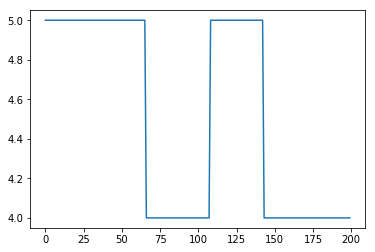

In [63]:
plotCarLaneIDOverTime(listOfSims4TimeWindow1[0]['laneNum'],1,verbose=True)